# Importing useful libraries and scripts

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json

import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor


# Helper functions

In [2]:
'''

This function takes a value and checks if it is a float and returns false if it is
another data type

'''
def is_float(x):

    try:
        float(x)
        
    except:
        return False

    return True

In [3]:
'''

A helper function that changes total square feet values of shape like (a - b)
into their average value i.e. (a+b) / 2 . For other types of values it will check
if the value is float and change the value to float and if not then it will return none.

'''

def convert_sqft_to_float(x):

    floats_ = x.split('-')

    if len(floats_) == 2:

        return ( (float(floats_[0]) + float(floats_[1])) / 2 )
    try:

        return float(x)

    except:

        return None

In [4]:
'''

This helper function will receive a data frame and normalize the price per square feet column.
We used the Gaussian distribution method to remove all the outliers.

We assumed a value will be an outlier if it occurs in the range out of (mean-std) upto (mean+std)

'''

def remove_pps_outlier(df):
    
    df_out = pd.DataFrame()

    for key,subdf in df.groupby('location'):

        m = np.mean(subdf.price_per_sqft)
        std = np.std(subdf.price_per_sqft)
        normal_df = subdf[(subdf.price_per_sqft > (m -std)) & (subdf.price_per_sqft < (m + std))]

        df_out = pd.concat([df_out,normal_df],ignore_index=True)

    return df_out

In [5]:
'''

A scatter plotting helper to see the outliers clearly.
The function will recieve dataframe and location as an input and scatter plots the 2 bedroom and 3 bedroom
comparision of price.

'''

def plot_scatter(df,location,title = None):

    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]

    plt.scatter(bhk2.total_sqft,bhk2.price,color='b',label='2 BHK', s= 50)
    plt.scatter(bhk3.total_sqft,bhk3.price,color='g',marker='+',label='3 BHK', s= 50)

    plt.xlabel('Total Square Feet')
    plt.ylabel('Price')

    if title != None:
        plt.title(title)

    else: plt.title(location)

    plt.legend(loc='best')
    

In [6]:
'''

This helper function will remove outliers existing in our bhk column. It will recieve
a data frame as an input and group it by location then do mean, standard deviation and 
count analysis. 

'''

def remove_bhk_outlier(df):

    exclude_idx = np.array([])

    for location, location_df in df.groupby('location'):

        bhk_stats = {}

        for bhk,bhk_df in location_df.groupby('bhk'):

            # Creating a dictionary containing all te relevant statstical information about the bhks

            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        
        for bhk,bhk_df in location_df.groupby('bhk'):

            # For the the current bhk lets take the previous bhk
            # Since we should see the less number of bhk to detect as an outlier

            stats = bhk_stats.get(bhk - 1)

            if stats and stats['count'] > 5:
                
                # We conclude that a higher number of bhk should have higher price
                # So we remove all the houses where higher number of bedrooms having the same square feet that cost less
                
                exclude_idx = np.append(exclude_idx,bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)

        
    return df.drop(exclude_idx,axis='index') 

In [7]:

'''

A helper function that recieves a dataframe and column to plot the scatter plot.

'''

def hist_plot(df,col):

    plt.hist(df[col],rwidth=0.8)
    plt.xlabel(f'{col}')
    plt.ylabel('Count')
    plt.show()

# Reading and loading the data

In [8]:
# After downloading the data lets read the data using pandas

df1 = pd.read_csv('../data/house_price.xls')
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


# Feature extraction

In [9]:
# Lets check how many rows and columns our data has

df1.shape

(13320, 9)

In [10]:
# Lets check how many unique area types exist

df1.area_type.unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [11]:
# From the above cell we can see that there are 4 distinct area types then lets see their value counts

df1.area_type.value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

In [12]:
# For our model building we can drop some unnecassary columns like society, balcony, area type ...

df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [13]:
# After droping those columns lets see how many columns we are left with

df2.shape

(13320, 5)

# Data cleaning (Null value detection)

In [14]:
# Lets see how many null values are present in each column

df2.isna().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [15]:
# From the above cell we can see there are multiple null values so lets drop them

df3 = df2.dropna()
df3.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [16]:
# Lets see how many training examples were having null values
 
print('Before null value droping the size was:',df2.shape)
print('After null value droping the size was:',df3.shape)
print(f'There were {df2.shape[0] - df3.shape[0]} examples having null values')


Before null value droping the size was: (13320, 5)
After null value droping the size was: (13246, 5)
There were 74 examples having null values


# Data cleaning (feature values exploring to make them readable and excutable)

In [17]:
# BHK (Bedroom, Hull, Kitchen) 
# The size column can be seen that it contains both number and string, it is the number that we need
# So lets do some lambda function to take only the integer part

df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [18]:
# Lets see some values of our total square feet column

df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [19]:
# Lets see how many examples exist where the values of total square feet is not float number

df3[~df3['total_sqft'].apply(is_float)].shape

(190, 6)

In [20]:
# Lets see those examples having total square feet value of not float number

df3[~df3['total_sqft'].apply(is_float)].head()

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2


In [21]:
# Lets create a new dataframe

df4 = df3.copy()

# Lets convert all the range valued square feet values to float by using our helper function

df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_float)
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [22]:
# Lets see our helper function effect

print('Before applying our helper function:',df3.loc[122]['total_sqft'])
print('After applying our helper function:',df4.loc[122]['total_sqft'])

Before applying our helper function: 3067 - 8156
After applying our helper function: 5611.5


In [23]:
# By using our helper function we changed the range values into float 
# But there are some null values our function returns lets check that

df4.isna().sum()

location       0
size           0
total_sqft    46
bath           0
price          0
bhk            0
dtype: int64

In [24]:
# Lets drop all the null values and verify there are no null values

df4 = df4.dropna()
df4.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
bhk           0
dtype: int64

# Data cleaning (PCA or dimensionality reduction)

In [25]:
# Lets create a new dataframe by copying the previous 

df5 = df4.copy()

'''
Lets create new column for price per square feet that we will use later 
for outlier detection
'''

df5['price_per_sqft'] = df5['price'] * 100000 / df5['total_sqft']
df5.head(3)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556


In [26]:
# Finding the mean and standard deviation of the price per square feet column

df5['price_per_sqft'].describe()

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [27]:
# Lets clean the location column by stripping all the white spaces before and after

df5.location = df5.location.apply(lambda x: x.strip())

# Lets create a location stats series that will be used to remove all location with very small numbers

location_stats = df5.location.value_counts()
location_stats

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

In [28]:
# Ensure that all the location has at least 1 corresponding another values 
# Total number of examples we have at this stage = 13200 

location_stats.sum()

13200

In [29]:
# Lets see how many locations has more than 10 houses in our dataset

len(location_stats[location_stats>10])

240

In [30]:
# Lets see how many unique locations are in our dataset

len(location_stats)

1287

In [31]:
# Lets see how many locations are there with less than 10 houses in our dataset

len(location_stats[location_stats<=10])

1047

In [32]:
# Lets see the locationstats with less than 10 houses in the dataset

location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10.head()

BTM 1st Stage           10
Gunjur Palya            10
Nagappa Reddy Layout    10
Sector 1 HSR Layout     10
Thyagaraja Nagar        10
Name: location, dtype: int64

In [33]:
# For all the locations having less than 10 houses we will caatagorize all of them under 'other' type
# This our dimensionality reduction step

df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

# 240 from all the locations and 1 for 'other'

len(df5.location.unique())

241

# Data cleaning (Outlier detection and removig)

In [34]:
# From analysis it has been seen that a house having a square feet to bhk ratio less than 3 is very rare
# Lets see those houses that we point out as an outliers

df5[df5.total_sqft / df5.bhk < 300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [35]:
# Lets create a new data frame by removing all the outlier houses

df6 = df5[~(df5.total_sqft / df5.bhk < 300)]
df6.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [36]:
# Removing outliers from the price per square feet column

df7 = remove_pps_outlier(df6)
df7.shape

(10242, 7)

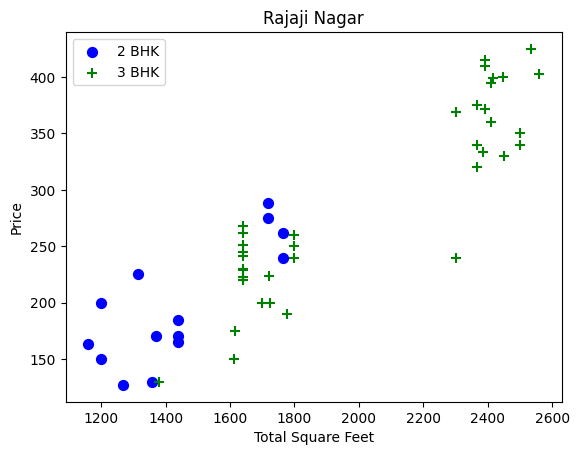

In [37]:
'''

From this graph we can clearly see that for the same square feet more number of bhks are
costing less. Which is clearly not correct. We know these examples are outliers that we should
deal with them.

'''

plot_scatter(df7,'Rajaji Nagar')

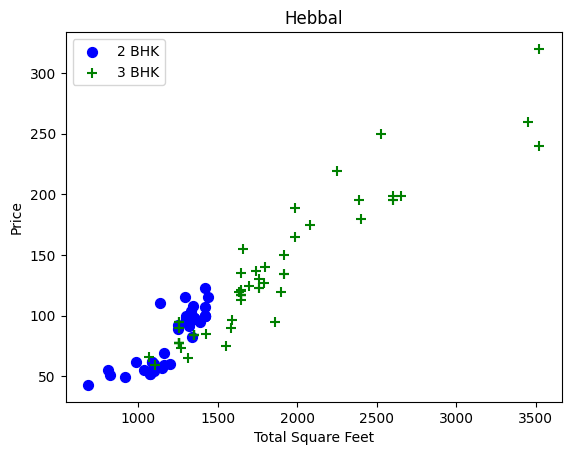

In [38]:
# Lets see some outliers for another location too

plot_scatter(df7,'Hebbal')

In [39]:
# Lets create a new dataframe to have all the fixed outliers 

df8 = remove_bhk_outlier(df7)
df8.shape

(7317, 7)

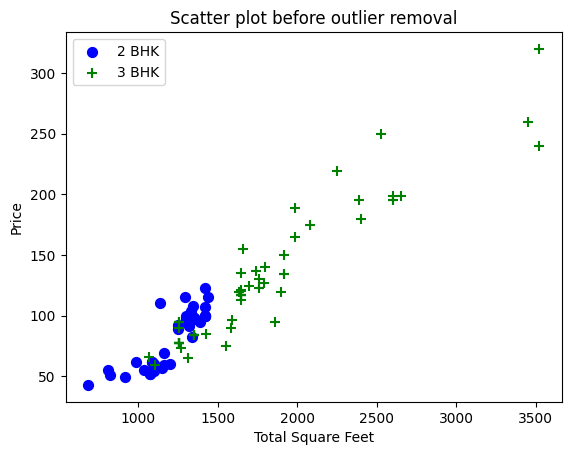

In [40]:
# Lets plot the graph of a certain location before outlier removal

plot_scatter(df7,'Hebbal','Scatter plot before outlier removal')

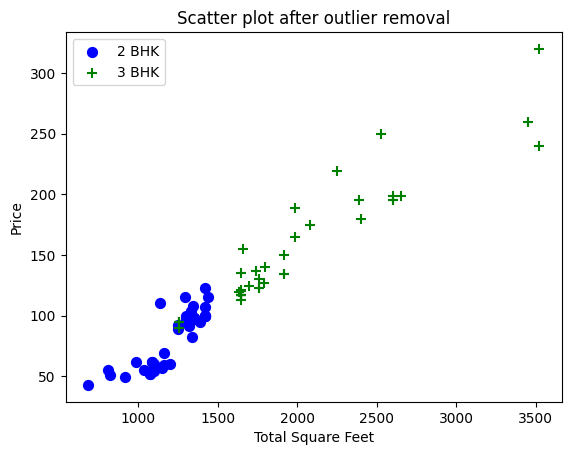

In [41]:
# Now lets plot the graph after fixing the ouliers

plot_scatter(df8,'Hebbal','Scatter plot after outlier removal')

> From the above graph comparision we can clearly see that all the gree ticks has disappeared i.e. we have fixed
the outliers successfuly

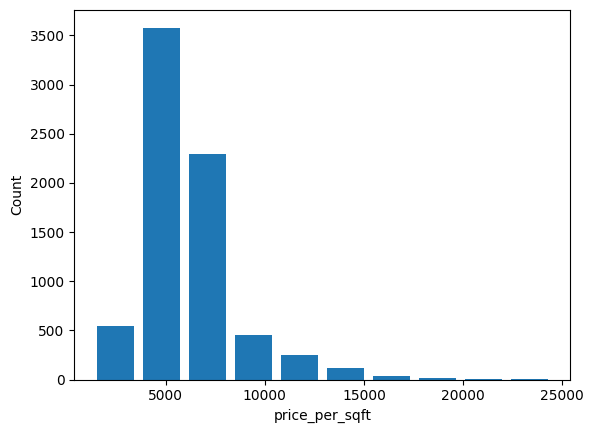

In [42]:
# Lets plot the price per square feet column and check if it follows a normal distribution

hist_plot(df8,'price_per_sqft')

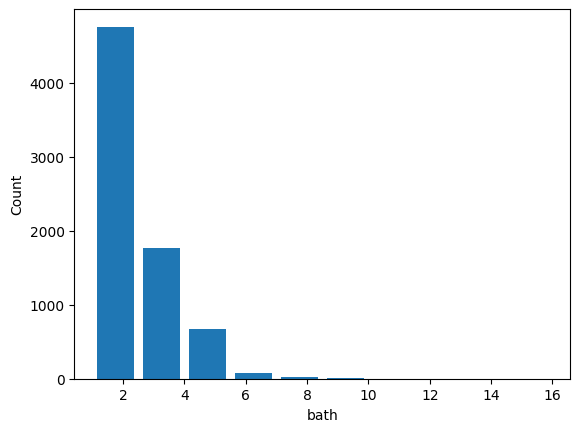

In [43]:
# Checking the bathroom number if it follows a normal distribution

hist_plot(df8,'bath')

In [44]:
# From analysis we have deduced that houses with number of bath rooms having more than 10 is rare
# Lets see houses having more than 10 bathrooms

df8[df8.bath>10].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


In [45]:
'''

Given the fact for wider house we may have more than 10 bathrooms but it is not normal to have
a house with that has 2 more bathrooms than bedrooms. So we will see the house having such kind of nature

'''

df8[df8.bath > df8.bhk + 2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [46]:
# From the above cell we see that there are 4 houses that we identify as an outlier
# So we drop those and create a new dataframe

df9 = df8[df8.bath < df8.bhk + 2]
df9.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [47]:
# Lets drop the size column since we have the bhk column
# Lets also drop the price per square feet column since we needed it to remove outlier
# We already removed all the outliers in our dataset so we can remove it now

df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


# One hot encoding of catagorical columns

In [48]:
# We know that the location column is string so to feed this column to our model we need to change it into number
# So we can do one hot encoding using pandas method calling get_dummies on that column

dummies = pd.get_dummies(df10.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# Lets create a new dataframe having dropped the other location column from the onehot encoded location columns

df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Lets drop the others column since we don't need it in our modeling and prediction phase

df12 = df11.drop('location',axis='columns')
df12.shape

(7239, 244)

# Creating a csv file from our cleaned dataframe

In [51]:
df12.to_csv('../data/clean_data.csv',index=False)